# Services notebook

# Aims and objectives

- Identify correct ICU classification for each ICU stay (as ICU into which a patient was admitted may not be the best ICU to suit their needs due to effects such as boarding)


# Import packages

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import numpy as np

# Read in files

In [2]:
# Read in files

#os.chdir("/Users/chloemaine/Documents/Chloe/BGSE/masters_project/raw_data")
ser = pd.read_csv('../input_data/services.csv')
pdeets = pd.read_csv('../input_data/patient_details.csv')

# ser = ser.loc[:, ['SUBJECT_ID', 'HADM_ID', 'CURR_SERVICE', 'FIRST_CAREUNIT']]

# Define functions

In [3]:
# Function to assign best ICU according to service
def which_icu(service):
    
    # Newborns should be in the NICU
    if service == 'NB' or service == 'NBB':
        icu = 'NICU'
    
    # Non surgical cardiac admissions in the CCU
    elif service == 'CMED':
        icu = 'CCU'
    
    # Surgical cardiac admissions in the CSRU
    elif service == 'CSURG':
        icu = 'CSRU'
    
    # Non surgical, mental and general medicine in the MICU
    elif service == 'MED' or service == 'OMED' or service == 'NMED' or service == 'PSYCH':
        icu = 'MICU'
    
    # Trauma in the TSICU
    elif service == 'TRAUM':
        icu = 'TSICU'
    
    # Surgeries in either the TSICU or SICU
    elif service == 'TSURG' or service == 'VSURG' or service == 'PSURG' or service == 'SURG' or service == 'ORTHO' or service == 'NSURG' or service == 'OBS':
        icu = 'SICU TSICU'
    
    # Others should not be in the cardiac or neonatal units
    elif service == 'DENT' or service == 'ENT' or service == 'GU' or service == 'GYN' :
        icu = 'SICU TSICU MICU' 

    else : icu = 'unknown'
    return(icu)

# Function to identify if actual ICU is in list of best ICU
# Function to identify if actual ICU is in list of best ICU
def match_ICU(df):
    
    df.loc[:, 'best_ICU'] = df.loc[:, 'CURR_SERVICE'].apply(lambda x : which_icu(x)) # Best ICU describes which ICU a patient should be in
    
    # Precalculate lists to improve performance
    FC = df.FIRST_CAREUNIT
    BICU = df.best_ICU
    
    # Initialise results lists
    results = [] # Whether or not there is match between best ICU and true ICU
    results_2 = [] # What the ICU should have been ('ideal ICU')
    
    # Initialise list for what to do with TSICU/SICU cases
    TSICUSICU = ['TSICU', 'SICU']
    
    # Initialise dictionary to count what happens with different replacements
    counts = {}
    counts['matches'] = 0
    counts['straight_replacement']=0
    counts['MICU assumption']=0
    counts['Surgery assumption']=0
    
    # Initialise counters
    j=0
    k=0
    
    for i in FC:
        
        # In the case that true ICU is the same as best ICU
        if i in BICU[j].split():
            results.append(True)
            results_2.append(i)
            counts['matches'] += 1

        else :
            results.append(False)
            
            # In the case that true ICU is not in the list of best ICUs, and there is only one ICU in best ICU
            if len(BICU[j].split()) == 1:
                results_2.append(BICU[j])
                counts['straight_replacement'] +=1
                
            # In the cases that true ICU is not in the list of best ICUs, and there is more than one best ICU in 
            # the best  ICU list
            
            # Case when best ICU could be either SICU, TSICU or MICU - we assume ideal ICU is the MICU
            elif BICU[j] == 'SICU TSICU MICU':
                results_2.append('MICU')
                counts['MICU assumption'] += 1
                
            # Case when best ICU could be either SICU or TSICU - we assume 50:50 distribution between the 2
            elif BICU[j] == 'SICU TSICU':
                results_2.append(TSICUSICU[k])
                counts['Surgery assumption'] += 1
                k += 1
                if k == 2: k = 0
                    
            else: results_2.append('Null')
                
        j+=1
    
    # Bind results to df
    df.loc[:, 'match_ICU'] = results
    df.loc[:, 'ideal_ICU'] = results_2
    
    
    return([df, counts])

# Pre-process dfs before merge

In [4]:
# Drop intime and outime - there are cases where a patient is double recorded a few minutes apart on entering
# To prevent duplicates occurring, we match on ICU STAY ID, HADM ID and SUBJECT ID
ser = ser.loc[:, ['SUBJECT_ID', 'HADM_ID', 'CURR_SERVICE','PREV_SERVICE', 
                  'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID', 'LOS', 'ICUSTAY_ID',
                  'FIRST_CAREUNIT']] 

ser= ser.drop_duplicates()

# Merge services with patient details 

In [5]:
# Now not required- done during query
# # Filter service table to only entries where patient is entering the hospital i.e. where previous service is null
# ser.PREV_SERVICE = ser.PREV_SERVICE.fillna('NULL')
# ser = ser.loc[ser.loc[:, 'PREV_SERVICE']== 'NULL',]

# Perform merge
merged_df = pdeets.merge(ser,
                         how = 'left',
                         left_on = ['hadm_id', 'subject_id', 'icustay_id'],
                         right_on = ['HADM_ID', 'SUBJECT_ID', 'ICUSTAY_ID'])


print("Merged df shape is", merged_df.shape)
print("Pdeets df shape is", pdeets.shape)
if merged_df.shape[0] == pdeets.shape[0]:
    print('MATCH!')
else: print("Something's up")
    
merged_df.iloc[0:5, :]

Merged df shape is (61532, 30)
Pdeets df shape is (61532, 20)
MATCH!


,subject_id,hadm_id,icustay_id,gender,dod,admittime,dischtime,los_hospital,age,ethnicity,...,SUBJECT_ID,HADM_ID,CURR_SERVICE,PREV_SERVICE,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,LOS,ICUSTAY_ID,FIRST_CAREUNIT
0,2,163353,243653,M,NaN,2138-07-17 19:04:00,2138-07-21 15:48:00,4,0,ASIAN,...,2.0,163353.0,NB,NaN,NICU,56.0,56.0,0.0918,243653.0,NICU
1,3,145834,211552,M,2102-06-14 00:00:00,2101-10-20 19:08:00,2101-10-31 13:58:00,11,76,WHITE,...,3.0,145834.0,VSURG,NaN,MICU,12.0,12.0,6.0646,211552.0,MICU
2,4,185777,294638,F,NaN,2191-03-16 00:28:00,2191-03-23 18:41:00,7,48,WHITE,...,4.0,185777.0,MED,NaN,MICU,52.0,52.0,1.6785,294638.0,MICU
3,5,178980,214757,M,NaN,2103-02-02 04:31:00,2103-02-04 12:15:00,2,0,ASIAN,...,5.0,178980.0,NB,NaN,NICU,56.0,56.0,0.0844,214757.0,NICU
4,6,107064,228232,F,NaN,2175-05-30 07:15:00,2175-06-15 16:00:00,16,66,WHITE,...,6.0,107064.0,SURG,NaN,SICU,33.0,33.0,3.6729,228232.0,SICU


# Investigate services admitted per ICU

In [6]:
# Create results dataframe

icu_list = ['NICU', 'MICU', 'CSRU', 'CCU', 'SICU', 'TSICU']

results = []
for icu in icu_list:
    results.append(merged_df.loc[merged_df.loc[:,'FIRST_CAREUNIT']== icu, ].groupby('CURR_SERVICE').icustay_id.count())

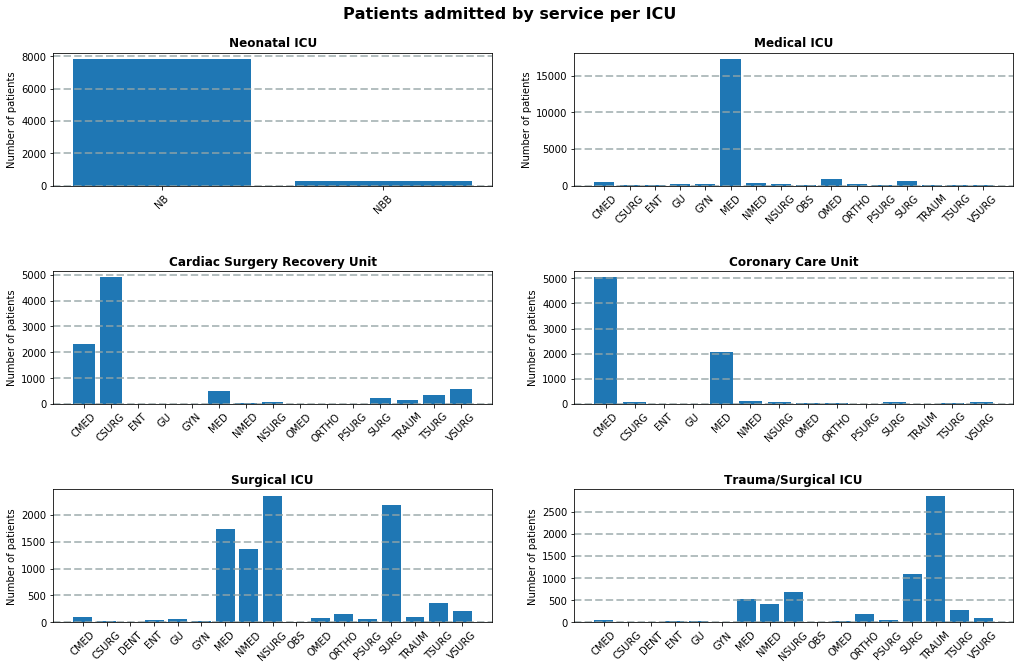

In [7]:
# Plot results

f, axs = plt.subplots(3,2, figsize=(14.8, 12), sharex = True, sharey = True)
icu_labels = ['Neonatal ICU', 'Medical ICU', 'Cardiac Surgery Recovery Unit', 'Coronary Care Unit', 'Surgical ICU', 'Trauma/Surgical ICU']

for icu in range(0, len(results)):
    
    labels = results[icu].index
    plt.subplot(4, 2, icu+1)
    plt.bar(labels, results[icu])
    plt.title(icu_labels[icu],  fontweight='bold')
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
    plt.ylabel('Number of patients')
    plt.xticks(labels, rotation = 45)

    

f.suptitle('Patients admitted by service per ICU', fontsize=16, fontweight = 'bold', y = 1)
f.tight_layout(pad=3.0)
plt.show()

# Investigate best versus true ICU

In [8]:
# Identify which ICU(s) would be best based on for which service patient was admitted
merged_df.loc[:, 'best_ICU'] = merged_df.loc[:, 'CURR_SERVICE'].apply(lambda x : which_icu(x))

# Identify if actual ICU is in list of best ICUs     
merged_df, counts = match_ICU(merged_df)
        
# # Count how many patients were admitted to their best ICU- match/non-match ICU
# merged_df.groupby('match_ICU').match_ICU.count()

counts

{'matches': 47927,
 'straight_replacement': 10624,
 'MICU assumption': 21,
 'Surgery assumption': 2960}

In [9]:
21/61532

0.00034128583501267634

In [10]:
sum(counts.values())

61532

In [11]:
merged_df.iloc[0:5, ]

,subject_id,hadm_id,icustay_id,gender,dod,admittime,dischtime,los_hospital,age,ethnicity,...,PREV_SERVICE,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,LOS,ICUSTAY_ID,FIRST_CAREUNIT,best_ICU,match_ICU,ideal_ICU
0,2,163353,243653,M,NaN,2138-07-17 19:04:00,2138-07-21 15:48:00,4,0,ASIAN,...,NaN,NICU,56.0,56.0,0.0918,243653.0,NICU,NICU,True,NICU
1,3,145834,211552,M,2102-06-14 00:00:00,2101-10-20 19:08:00,2101-10-31 13:58:00,11,76,WHITE,...,NaN,MICU,12.0,12.0,6.0646,211552.0,MICU,SICU TSICU,False,TSICU
2,4,185777,294638,F,NaN,2191-03-16 00:28:00,2191-03-23 18:41:00,7,48,WHITE,...,NaN,MICU,52.0,52.0,1.6785,294638.0,MICU,MICU,True,MICU
3,5,178980,214757,M,NaN,2103-02-02 04:31:00,2103-02-04 12:15:00,2,0,ASIAN,...,NaN,NICU,56.0,56.0,0.0844,214757.0,NICU,NICU,True,NICU
4,6,107064,228232,F,NaN,2175-05-30 07:15:00,2175-06-15 16:00:00,16,66,WHITE,...,NaN,SICU,33.0,33.0,3.6729,228232.0,SICU,SICU TSICU,True,SICU


In [12]:
# Check there are no unmatched ICU counts
unmatched_icu_counts = merged_df.loc[merged_df.loc[:, 'ideal_ICU']=='Null', ].groupby('best_ICU').best_ICU.count()
unmatched_icu_counts

Series([], Name: best_ICU, dtype: int64)

In [13]:
# Check distribution between TSICU and SICU
cu_counts = merged_df.groupby('FIRST_CAREUNIT').FIRST_CAREUNIT.describe().loc[:, 'count']
cu_counts.iloc[[4,5]]/sum(cu_counts.iloc[[4,5]])

FIRST_CAREUNIT
SICU     0.580447
TSICU    0.419553
Name: count, dtype: object

In [47]:
merged_df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'dod', 'admittime',
       'dischtime', 'los_hospital', 'age', 'ethnicity', 'ethnicity_grouped',
       'admission_type', 'hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq',
       'first_icu_stay', 'SUBJECT_ID', 'HADM_ID', 'CURR_SERVICE',
       'PREV_SERVICE', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID', 'LOS',
       'ICUSTAY_ID', 'FIRST_CAREUNIT', 'best_ICU', 'match_ICU', 'ideal_ICU'],
      dtype='object')

In [14]:
merged_df.head()

,subject_id,hadm_id,icustay_id,gender,dod,admittime,dischtime,los_hospital,age,ethnicity,...,PREV_SERVICE,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,LOS,ICUSTAY_ID,FIRST_CAREUNIT,best_ICU,match_ICU,ideal_ICU
0,2,163353,243653,M,NaN,2138-07-17 19:04:00,2138-07-21 15:48:00,4,0,ASIAN,...,NaN,NICU,56.0,56.0,0.0918,243653.0,NICU,NICU,True,NICU
1,3,145834,211552,M,2102-06-14 00:00:00,2101-10-20 19:08:00,2101-10-31 13:58:00,11,76,WHITE,...,NaN,MICU,12.0,12.0,6.0646,211552.0,MICU,SICU TSICU,False,TSICU
2,4,185777,294638,F,NaN,2191-03-16 00:28:00,2191-03-23 18:41:00,7,48,WHITE,...,NaN,MICU,52.0,52.0,1.6785,294638.0,MICU,MICU,True,MICU
3,5,178980,214757,M,NaN,2103-02-02 04:31:00,2103-02-04 12:15:00,2,0,ASIAN,...,NaN,NICU,56.0,56.0,0.0844,214757.0,NICU,NICU,True,NICU
4,6,107064,228232,F,NaN,2175-05-30 07:15:00,2175-06-15 16:00:00,16,66,WHITE,...,NaN,SICU,33.0,33.0,3.6729,228232.0,SICU,SICU TSICU,True,SICU


In [15]:
os.chdir("/Users/chloemaine/Documents/Chloe/BGSE/masters_project/processed_data")
merged_df.to_csv('patient_details_idealicu.csv', index=False)

In [16]:
merged_df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'dod', 'admittime',
       'dischtime', 'los_hospital', 'age', 'ethnicity', 'ethnicity_grouped',
       'admission_type', 'hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq',
       'first_icu_stay', 'SUBJECT_ID', 'HADM_ID', 'CURR_SERVICE',
       'PREV_SERVICE', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID', 'LOS',
       'ICUSTAY_ID', 'FIRST_CAREUNIT', 'best_ICU', 'match_ICU', 'ideal_ICU'],
      dtype='object')

# Investigate change in services after ideal ICU calculated

In [17]:
icu_list = ['NICU', 'MICU', 'CSRU', 'CCU', 'SICU', 'TSICU']

iresults = []
for icu in icu_list:
    iresults.append(merged_df.loc[merged_df.loc[:,'ideal_ICU']== icu, ].groupby('CURR_SERVICE').icustay_id.count())

In [18]:
all_results = pd.DataFrame()
i = 0
for n, icu in enumerate(icu_list):
    for idx, df in [['original_ICU', results], ['ideal_ICU', iresults]]:
        for ser in df[n].index:
            all_results.loc[i, 'number'] = df[n].loc[ser]
            all_results.loc[i, 'icu'] = icu 
            all_results.loc[i, 'ser'] = ser
            all_results.loc[i, 'type'] = idx
            i+=1

In [19]:
all_results.ser.unique()

array(['NB', 'NBB', 'CMED', 'CSURG', 'ENT', 'GU', 'GYN', 'MED', 'NMED',
       'NSURG', 'OBS', 'OMED', 'ORTHO', 'PSURG', 'SURG', 'TRAUM', 'TSURG',
       'VSURG', 'DENT'], dtype=object)

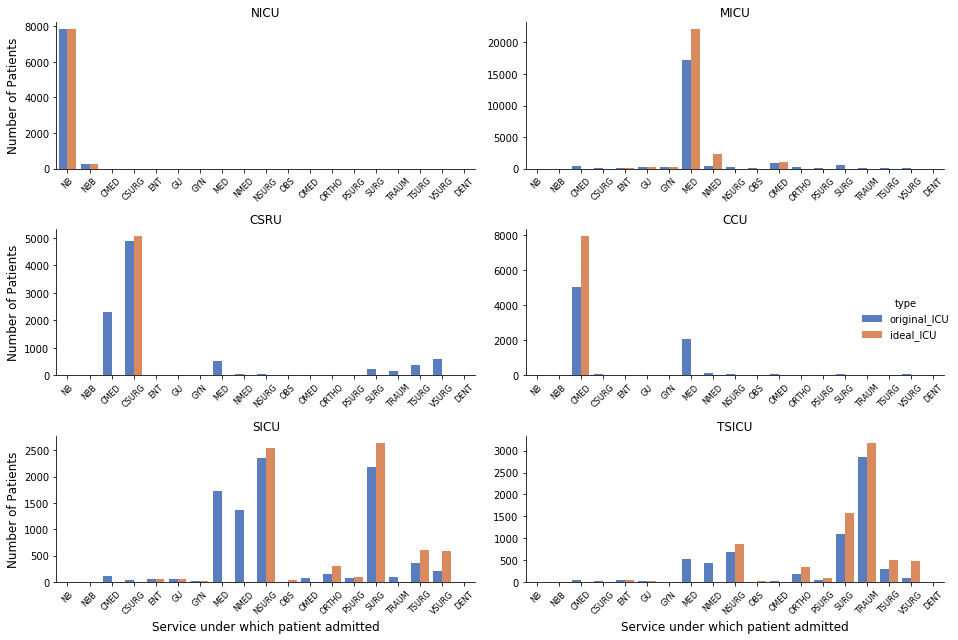

In [20]:
import seaborn as sns
g = sns.catplot(x="ser", y="number", hue="type", data=all_results,
                kind="bar", palette="muted", ci = None,
                col = "icu", col_wrap = 2, sharey = False, sharex = False, 
               legend_out = True,  height=3, aspect=2)

g.set_ylabels("Number of Patients", size = 12)
g.set_xlabels("Service under which patient admitted", size = 12)
g.set_titles("{col_name}", size =12)

g.set_xticklabels(all_results.ser.unique(), rotation=45, size = 8)

plt.tight_layout()
plt.show()


os.chdir("/Users/chloemaine/Documents/Chloe/BGSE/masters_project/graphs")
g.savefig('admitted_services.png', dpi=100)

In [21]:
for icu in range(0, len(results)):
    print(icu_list[icu])
    print('Original', sum(results[icu]))
    print('Ideal',  sum(iresults[icu]))
    print('Difference',  sum(iresults[icu]) - sum(results[icu]))

NICU
Original 8081
Ideal 8081
Difference 0
MICU
Original 21006
Ideal 26065
Difference 5059
CSRU
Original 9201
Ideal 5069
Difference -4132
CCU
Original 7679
Ideal 7937
Difference 258
SICU
Original 8864
Ideal 6939
Difference -1925
TSICU
Original 6407
Ideal 7147
Difference 740


In [22]:
merged_df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'dod', 'admittime',
       'dischtime', 'los_hospital', 'age', 'ethnicity', 'ethnicity_grouped',
       'admission_type', 'hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq',
       'first_icu_stay', 'SUBJECT_ID', 'HADM_ID', 'CURR_SERVICE',
       'PREV_SERVICE', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID', 'LOS',
       'ICUSTAY_ID', 'FIRST_CAREUNIT', 'best_ICU', 'match_ICU', 'ideal_ICU'],
      dtype='object')

In [23]:
for icu in icu_list:
    print(icu, merged_df.loc[merged_df.loc[:, 'FIRST_CAREUNIT'] == icu, ].groupby('admission_type').icustay_id.count())
    print(icu, merged_df.loc[merged_df.loc[:, 'FIRST_CAREUNIT'] == icu, ].groupby('admission_type').icustay_id.count()/sum(merged_df.loc[merged_df.loc[:, 'FIRST_CAREUNIT'] == icu, ].groupby('admission_type').icustay_id.count()))

NICU admission_type
ELECTIVE        2
EMERGENCY     198
NEWBORN      7859
URGENT         22
Name: icustay_id, dtype: int64
NICU admission_type
ELECTIVE     0.000247
EMERGENCY    0.024502
NEWBORN      0.972528
URGENT       0.002722
Name: icustay_id, dtype: float64
MICU admission_type
ELECTIVE       886
EMERGENCY    19694
URGENT         426
Name: icustay_id, dtype: int64
MICU admission_type
ELECTIVE     0.042178
EMERGENCY    0.937542
URGENT       0.020280
Name: icustay_id, dtype: float64
CSRU admission_type
ELECTIVE     3908
EMERGENCY    4940
URGENT        353
Name: icustay_id, dtype: int64
CSRU admission_type
ELECTIVE     0.424736
EMERGENCY    0.536898
URGENT       0.038365
Name: icustay_id, dtype: float64
CCU admission_type
ELECTIVE      384
EMERGENCY    6930
URGENT        365
Name: icustay_id, dtype: int64
CCU admission_type
ELECTIVE     0.050007
EMERGENCY    0.902461
URGENT       0.047532
Name: icustay_id, dtype: float64
SICU admission_type
ELECTIVE     1511
EMERGENCY    7159
URGENT 

# Compare distribution of boarding and non-boarding patients

In [24]:
print("Number of 
      patients in original ICUs", all_results.loc[all_results.loc[:, 'type']=='original_ICU'].number.sum())
print("Number of patients assigned ideal ICU", all_results.loc[all_results.loc[:, 'type']=='ideal_ICU'].number.sum())

Number of patients in original ICUs 61238.0
Number of patients assigned ideal ICU 61238.0


In [24]:
non_matchers = merged_df.loc[merged_df.loc[:, 'ideal_ICU'] != merged_df.loc[:, 'FIRST_CAREUNIT'],].loc[:, ['los_hospital', 'age', 'hospital_expire_flag', 'los_icu', 'LOS']]
matchers = merged_df.loc[merged_df.loc[:, 'ideal_ICU'] == merged_df.loc[:, 'FIRST_CAREUNIT'],].loc[:, ['los_hospital', 'age', 'hospital_expire_flag', 'los_icu', 'LOS']]

In [25]:
type(non_matchers.los_icu.fillna(0))

pandas.core.series.Series

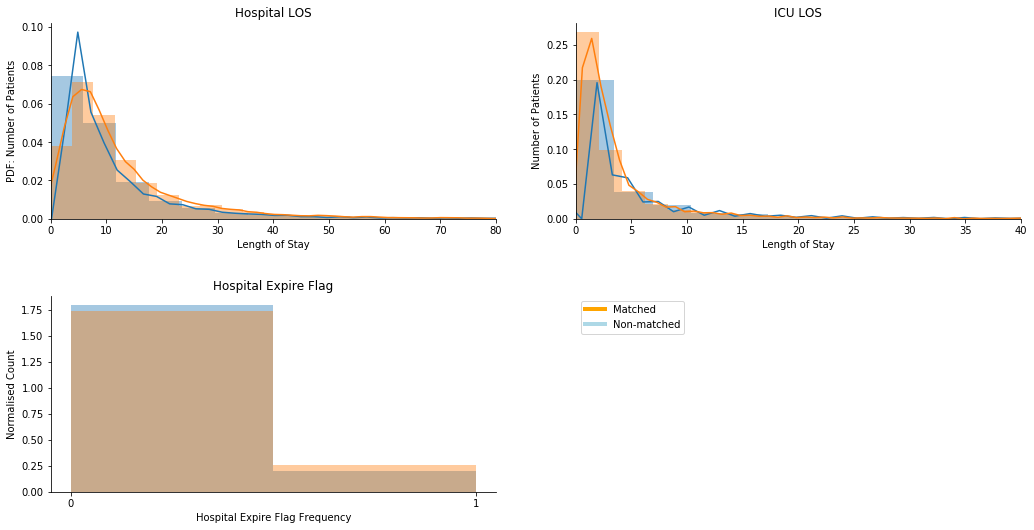

In [26]:
f, axes = plt.subplots(2, 2, figsize=(15, 8), sharex=False, sharey = False)

sns.distplot(matchers.los_hospital,  label="Matching ICU", kde = True, ax = axes[0,0]).set(xlim=(0,80), title = "Hospital LOS",)
sns.distplot(non_matchers.los_hospital, label="Non- matching ICU", kde = True,  ax = axes[0,0]).set(xlim=(0,80), xlabel = 'Length of Stay', ylabel = 'PDF: Number of Patients')

sns.distplot(matchers.los_icu.fillna(0), label="Matching ICU", kde = True, ax = axes[0,1]).set(xlim=(0,40), xlabel = 'Length of Stay', ylabel = 'PDF: Number of Patients',  title = "ICU LOS")
sns.distplot(non_matchers.los_icu.fillna(0), label="Non- matching ICU", kde = True,  ax = axes[0,1]).set(xlim=(0,40), xlabel = 'Length of Stay', ylabel = 'Number of Patients')

sns.distplot(matchers.hospital_expire_flag.fillna(0), kde = False, norm_hist = True,  bins =2, label="Matching ICU", ax = axes[1,0]).set(xlabel = 'Hospital Expire Flag Frequency',   title = "Hospital Expire Flag")
sns.distplot(non_matchers.hospital_expire_flag.fillna(0), kde = False, norm_hist = True, bins = 2, label="Non- matching ICU",  ax = axes[1,0]).set( xlabel = 'Hospital Expire Flag Frequency', ylabel = 'Normalised Count', xticks = [0,1])

plt.axis('off')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='lightblue', lw=4)]

plt.legend(custom_lines, ['Matched', 'Non-matched'], loc = 'upper left')
plt.tight_layout(pad = 3)
sns.despine(right =True, top = True)

f.savefig('matched_vs_unmatched_losdists.png', dpi=100)

In [27]:
# K-S Statistic for LOS hospital

A = matchers.groupby('los_hospital').LOS.count()
resA = []
for a in range(0, 300):
    if a in A.index:
        resA.append(A[a])
    else: 
        resA.append(0)
        
B = non_matchers.groupby('los_hospital').LOS.count()
resB = []
for b in range(0, 300):
    if b in B.index:
        resB.append(B[b])
    else: 
        resB.append(0)
        
        
ks_2samp(data1= np.array(resA), data2 =np.array(resB),
         alternative = 'two-sided')

Ks_2sampResult(statistic=0.16, pvalue=0.0009055129810100997)

In [28]:
# K-S Statistic for LOS ICU

A = matchers.groupby('los_icu').LOS.count()
resA = []
for a in range(0, 300):
    if a in A.index:
        resA.append(A[a])
    else: 
        resA.append(0)
        
B = non_matchers.groupby('los_icu').LOS.count()
resB = []
for b in range(0, 300):
    if b in B.index:
        resB.append(B[b])
    else: 
        resB.append(0)
        
        
ks_2samp(data1= np.array(resB), data2 =np.array(resA),
         alternative = 'two-sided')

Ks_2sampResult(statistic=0.2633333333333333, pvalue=1.4942294797261553e-09)

# Scenario modelling

In [31]:
print('Over 75', merged_df.loc[merged_df.loc[:, 'age'] >= 75, :].shape)
print('Under 75', merged_df.loc[merged_df.loc[:, 'age'] < 75, :].shape)

Over 75 (17143, 33)
Under 75 (44389, 33)


In [56]:
# From literature
over75_effect = 0.16
under75_effect = 0.04
# From dataframe
num_days = 4170
icus = ['CCU', 'CSRU', 'NICU', 'MICU', 'TSICU', 'SICU']

# Initialise results
res = np.zeros([len(icus), 3])

for i, icu in enumerate(icus):
    # Over 75s
    df = merged_df.loc[merged_df.loc[:, 'age'] >= 75, :]
    df = df.loc[df.loc[:, 'ideal_ICU'] == icu, :]
    res[i][0] = df.shape[0]
    
    # Under 75s
    df = merged_df.loc[merged_df.loc[:, 'age'] < 75, :]
    df = df.loc[df.loc[:, 'ideal_ICU'] == icu, :]
    res[i][1] = df.shape[0]
    
    # LOS per ICU
    icu_df =  merged_df.loc[merged_df.loc[:, 'ideal_ICU'] == icu, :]
    res[i][2] = np.mean(icu_df.LOS)
 
# Format dataframe
res = pd.DataFrame(res)
res.columns = ['over75', 'under75', 'LOS']
res.index = icus

# Convert from patient counts per day to additional patients admitted per day
res.over75 = (res.over75/num_days) * over75_effect
res.under75 = (res.under75/num_days) * under75_effect
res.loc[:, 'total'] = np.sum(res, axis = 1) - res.LOS

os.chdir("/Users/chloemaine/Documents/Chloe/BGSE/masters_project/processed_data")
res.to_csv('add_ads.csv', index=False)

In [57]:
res

,over75,under75,LOS,total
CCU,0.121746,0.045698,3.706869,0.167444
CSRU,0.056978,0.034379,3.636968,0.091357
NICU,0.000000,0.077516,10.011210,0.077516
MICU,0.328978,0.167779,4.031040,0.496758
TSICU,0.073823,0.050101,4.637214,0.123923
SICU,0.073516,0.048182,4.895090,0.121698
